# Using Gemini in AutoGen with Other LLMs

You don't need to handle OpenAI or Google's GenAI packages. AutoGen already handled all of these for you.

You can just create different agents with different backend LLM with assistant agent, and all models/agents are at your fingertip.


## Main Distinctions
- Gemini does not have the "system_message" field (correct me if I am wrong). So, it's instruction following skills are not as strong as GPTs.


Sample OAI_CONFIG_LIST 

```python
[
    {
        "model": "gpt-35-turbo",
        "api_key": "your OpenAI Key goes here",
        "base_url": "https://tnrllmproxy.azurewebsites.net/v1",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "gpt-4-vision-preview",
        "api_key": "your OpenAI Key goes here",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "dalle",
        "api_key": "your OpenAI Key goes here",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "gemini-pro",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    },
    {
        "model": "gemini-pro-vision",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    }
]
```

### Before everything starts, install AutoGen with the `gemini` option
```bash
pip install "pyautogen[gemini]~=0.2.0b4"
```


#### Install These Missing Packages Manually if You Encounter Any Errors
```bash
pip install https://github.com/microsoft/autogen/archive/gemini.zip
pip install "google-generativeai" "pydash" "pillow"
```

In [1]:
import requests
import json
import pdb
import os
import re

from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent, ConversableAgent

from autogen.agentchat.contrib.img_utils import get_image_data, _to_pil
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

from termcolor import colored
import random

from autogen.code_utils import DEFAULT_MODEL, UNKNOWN, content_str, execute_code, extract_code, infer_lang

In [2]:
import os
import PIL
import matplotlib.pyplot as plt

In [3]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

config_list_gemini = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro"],
    },
)

config_list_gemini_vision = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro-vision"],
    },
)

## Gemini Assitant


In [4]:
assistant = AssistantAgent(
    "assistant", llm_config={"config_list": config_list_gemini, "seed": 42}, max_consecutive_auto_reply=3
)
# print(assistant.system_message)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)

user_proxy.initiate_chat(assistant, message="Sort the array with Bubble Sort: [4, 1, 3, 2]")

user_proxy (to assistant):

Sort the array with Bubble Sort: [4, 1, 3, 2]

--------------------------------------------------------------------------------
assistant (to user_proxy):

```python
# filename: bubble_sort.py
def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(0, n-i-1):
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr

if __name__ == "__main__":
    arr = [4, 1, 3, 2]
    print("Unsorted array: ", arr)
    sorted_arr = bubble_sort(arr)
    print("Sorted array: ", sorted_arr)
```

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
Unsorted array:  [4, 1, 3, 2]
Sorted array:  [1, 2, 3, 4]


--------------------------------------------------------------------------------
assistant (to user_proxy):

TERMINATE

--------------

## Agent Collaboration and Interactions



In [5]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""Always answer questions within one sentence. """,
    #                      system_message="answer:",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=4,
)


gpt.initiate_chat(gemini, message="Do Transformers buy auto insurance or health insurance?")

GPT-4 (to Gemini-Pro):

Do Transformers buy auto insurance or health insurance?

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

Transformers, being fictional robots, do not require auto or health insurance.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

If Transformers were real and required insurance, would their coverage be a specialized form of property insurance instead of typical auto or health insurance?

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

Yes, if Transformers were real and required insurance, their coverage would likely be a specialized form of property insurance designed specifically for sentient robotic beings.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

Considering their dual nature as vehicles and sentient beings, could they poten

Let's switch position. Now, Gemini is the question raiser. 

This time, Gemini could not follow the system instruction well or evolve questions, because the Gemini does not handle system messages similar to GPTs.

In [6]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""Always answer questions within one sentence. """,
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=4,
)

gemini.initiate_chat(gpt, message="Should Spider-Man invest in 401K?")

Gemini-Pro (to GPT-4):

Should Spider-Man invest in 401K?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

As a fictional character, Spider-Man does not require a 401(k), but his alter ego, if employed with such benefits, might consider it for retirement savings.

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

If the sun sneezes, does it become stars?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

No, a sneeze is a biological function that the sun, being a star, cannot perform.

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

If you could have any animal as your neighbor, who would it be and why a giraffe?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

A giraffe could be an interesting neighbor due to

## Gemini RAG

Here we will be exploring RAG with Gemini. Note that Gemini will raise a 500 error if a message is an empty string. To prevent this, we set the `default_auto_reply` to `Reply plaintext TERMINATE to exit.` for the `ragproxyagent`.

In [7]:
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
import chromadb
import os

# 1. create an RetrieveAssistantAgent instance named "assistant"
assistant = RetrieveAssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list_gemini,
    },
)

# 2. create the RetrieveUserProxyAgent instance named "ragproxyagent"
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    default_auto_reply="Reply plaintext TERMINATE to exit.",  # Gemini will raise 500 error if the response is empty.
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "code",
        "docs_path": [
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Examples/Integrate%20-%20Spark.md",
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Research.md",
            os.path.join(os.path.abspath(""), "..", "website", "docs"),
        ],
        "custom_text_types": ["mdx"],
        "chunk_token_size": 2000,
        "model": config_list_gemini[0]["model"],
        "client": chromadb.PersistentClient(path="/tmp/chromadb"),
        "embedding_model": "all-mpnet-base-v2",
        "get_or_create": True,  # set to False if you don't want to reuse an existing collection, but you'll need to remove the collection manually
    },
    code_execution_config=False,  # set to False if you don't want to execute the code
)

code_problem = "How can I use FLAML to perform a classification task and use spark to do parallel training. Train 30 seconds and force cancel jobs if time limit is reached."
ragproxyagent.initiate_chat(
    assistant, problem=code_problem, search_string="spark"
)  # search_string is used as an extra filter for the embeddings search, in this case, we only want to search documents that contain "spark".

Trying to create collection.
[2024-01-08 13:38:06,902] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Number of requested results 20 is greater than number of elements in index 4, updating n_results = 4
Model gemini-pro not found. Using cl100k_base encoding.


doc_ids:  [['doc_0']]
Adding doc_id doc_0 to context.
ragproxyagent (to assistant):

You're a retrieve augmented coding assistant. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
For code generation, you must obey the following rules:
Rule 1. You MUST NOT install any packages because all the packages needed are already installed.
Rule 2. You must follow the formats below to write your code:
```language
# your code
```

User's question is: How can I use FLAML to perform a classification task and use spark to do parallel training. Train 30 seconds and force cancel jobs if time limit is reached.

Context is: # Integrate - Spark

FLAML has integrated Spark for distributed training. There are two main aspects of integration with Spark:
- Use Spark ML estimators for AutoML.
- Use Spark to run training in parallel spark jobs.

## Spark 


--------------------------------------------------------------------------------
assistant (to ragproxyagent):

TERMINATE

--------------------------------------------------------------------------------


## Gemini Multimodal

You can create multimodal agent for Gemini the same way as the GPT-4V and LLaVA.


Note that the Gemini-pro-vision does not support chat yet. So, we only use the last message in the prompt for multi-turn chat. The behavior might be strange compared to GPT-4V and LLaVA models.

Here, we ask a question about 
![](https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true)

In [8]:
image_agent = MultimodalConversableAgent(
    "Gemini Vision", llm_config={"config_list": config_list_gemini_vision, "seed": 42}, max_consecutive_auto_reply=1
)

user_proxy = UserProxyAgent("user_proxy", human_input_mode="NEVER", max_consecutive_auto_reply=0)

# user_proxy.initiate_chat(image_agent,
#                          message="""What's the breed of this dog?
# <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

user_proxy.initiate_chat(
    image_agent,
    message="""What's this image about?
<img https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true>.""",
)

user_proxy (to Gemini Vision):

What's this image about? 
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Gemini Vision (to user_proxy):

 The image is about a user interacting with an assistant agent. The user wants to plot a chart of META and TSLA stock price change YTD. The assistant agent helps the user by executing the code and plotting the chart.

--------------------------------------------------------------------------------


## GroupChat with Gemini Agents

In [9]:
agent1 = AssistantAgent(
    "Gemini-agent",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=3,
    system_message="Answer questions about Google.",
    description="I am good at answering questions about Google and Research papers.",
)

agent2 = AssistantAgent(
    "GPT-agent",
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
    description="I am good at writing code.",
)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    max_consecutive_auto_reply=5,
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0
    or content_str(x.get("content")) == "",
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=12)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list_gemini, "seed": 42})

In [10]:
# user_proxy.initiate_chat(manager, message="Show me the release year of famous Google products.")
user_proxy.send("Show me the release year of famous Google products.", recipient=manager, request_reply=True)

user_proxy (to chat_manager):

Show me the release year of famous Google products.

--------------------------------------------------------------------------------
Gemini-agent (to chat_manager):

| Google Product | Release Year |
|---|---|
| Google Search | 1998 |
| Gmail | 2004 |
| Google Maps | 2005 |
| YouTube | 2005 |
| Google Chrome | 2008 |
| Android | 2008 |
| Google Apps | 2009 |
| Google Drive | 2012 |
| Google Play | 2012 |
| Google Home | 2016 |
| Google Pixel | 2016 |
| Google Assistant | 2016 |
| Google Lens | 2017 |
| Google Stadia | 2019 |

--------------------------------------------------------------------------------
user_proxy (to chat_manager):



--------------------------------------------------------------------------------


In [11]:
user_proxy.send(
    "Plot the products and years in scatterplot and save to `graph.png`", recipient=manager, request_reply=True
)

user_proxy (to chat_manager):

Plot the products and years in scatterplot and save to `graph.png`

--------------------------------------------------------------------------------
GPT-agent (to chat_manager):

To create and save a scatter plot with the products and years, we will use Python with libraries such as matplotlib for plotting. The user should ensure that matplotlib is installed in their Python environment; it can be installed using `pip install matplotlib`.

Below is the Python code that you can run to generate a scatter plot and save it as `graph.png`:

```python
# filename: create_scatter_plot.py
import matplotlib.pyplot as plt

# Defining the products and their release years
products = ['Google Search', 'Gmail', 'Google Maps', 'YouTube', 'Google Chrome', 
            'Android', 'Google Apps', 'Google Drive', 'Google Play', 'Google Home',
            'Google Pixel', 'Google Assistant', 'Google Lens', 'Google Stadia']
years = [1998, 2004, 2005, 2005, 2008, 2008, 2009, 2012,

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


user_proxy (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 


--------------------------------------------------------------------------------
user_proxy (to chat_manager):



--------------------------------------------------------------------------------


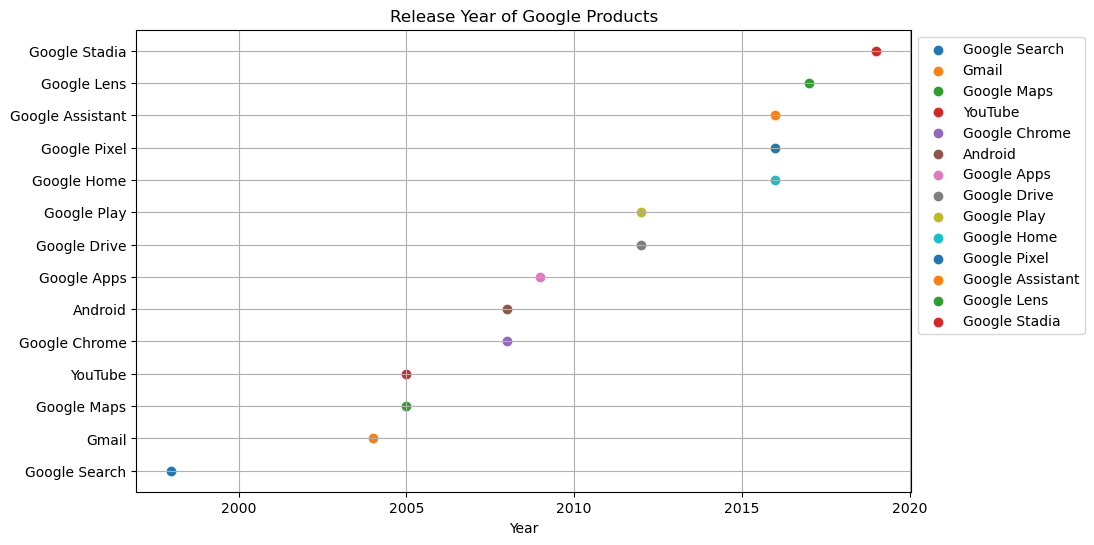

In [12]:
from PIL import Image

img = Image.open("coding/graph.png")
img

## A Larger Example of Group Chat

In [13]:
coder = AssistantAgent(
    name="Coder",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=10,
    description="I am good at writing code",
)

pm = AssistantAgent(
    name="Product_manager",
    system_message="Creative in software product ideas.",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=10,
    description="I am good at design products and software.",
)

user_proxy = UserProxyAgent(
    name="User_proxy",
    code_execution_config={"last_n_messages": 20, "work_dir": "coding", "use_docker": False},
    human_input_mode="TERMINATE",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, pm], messages=[], max_round=12)
manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config={"config_list": config_list_gemini, "seed": 42},
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)
user_proxy.initiate_chat(
    manager,
    message="""Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are.""",
)

User_proxy (to chat_manager):

Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are.

--------------------------------------------------------------------------------
Coder (to chat_manager):

```sh
# filename: install_dependencies.sh
pip install gemini
pip install torchvision
```

```sh
# filename: run_gemini.py
import gemini
import torchvision

# Load the image
image = torchvision.datasets.ImageFolder('path/to/image')

# Use Gemini to generate captions
captions = gemini.predict(image)

# Print the captions
for caption in captions:
    print(caption)
```

--------------------------------------------------------------------------------
Coder (to chat_manager):

```sh
# filename: run_object_detection.py
import gemini
import torchvision

# Load the image
image = torchvision.datasets.ImageFolder('path/to/image')

# Use Gemini to detec

## GPT  v.s. Gemini Arena

Do you remember AutoGen can ask LLMs to play chess. Here, we create an arena to allow GPT and Gemini fight together.